# Ch. 5 Fundamentals of machine learning

**Contents**
* 머신러닝의 근본적인 문제인 일반화와 최적화 사이의 긴장 이해
* 머신러닝 모델 평가 방법
* 모델 피팅 개선을 위한 최선의 조치
* 더 나은 일반화를 위한 모범 사례

## Generalization: The goal of machine learning

### Underfitting and overfitting

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-01.png" width="400"><p style="text-align:center">Figure 5.1 Canonical overfitting behavior</p>

모델은 다음과 같이 패턴을 학습합니다.

* 훈련 데이터에만 해당하는 것
* 그러나 그것은 새로운 데이터가 주어질 때 잘못 인식하거나 관련이 없을 수 있습니다.

과적합은 다음의 경우 발생할 가능성이 있습니다.:

* 데이터에 잡음이 많을 때
* 불확실성이 포함된 경우
* 희귀한 특징이 포함된 경우

#### Noisy training data

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-02.png" width="250"><p style="text-align:center">Figure 5.2 Some pretty weird MNIST training samples</p>

<br>
<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-03.png" width="350"><p style="text-align:center">Figure 5.3 Mislabeled MNIST training samples</p>

<br>
<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-04.png" width="350"><p style="text-align:center">Figure 5.4 Dealing with outliers: robust fit vs. overfitting</p>

#### Ambiguous features

Banana classifier:
* 0 : unripe
* 1 : ripe
* 2 : rotten

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-05.png" width="400"><p style="text-align:center">Figure 5.5 Robust fit vs. overfitting giving an ambiguous area of the feature space</p>

#### Rare features and spurious correlations

**Adding white-noise channels or all-zeros channels to MNIST**

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
print(train_images_with_noise_channels.shape)
print(train_images_with_zeros_channels.shape)

(60000, 1568)
(60000, 1568)


**Training the same model on MNIST data with noise channels or all-zero channels**

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 5s 4ms/step - loss: 0.6035 - accuracy: 0.8164 - val_loss: 0.3013 - val_accuracy: 0.9049
Epoch 2/10
375/375 [==============================] - 1s 4ms/step - loss: 0.2428 - accuracy: 0.9243 - val_loss: 0.2428 - val_accuracy: 0.9257
Epoch 3/10
375/375 [==============================] - 1s 4ms/step - loss: 0.1608 - accuracy: 0.9491 - val_loss: 0.1451 - val_accuracy: 0.9559
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1147 - accuracy: 0.9629 - val_loss: 0.1204 - val_accuracy: 0.9663
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0834 - accuracy: 0.9736 - val_loss: 0.1415 - val_accuracy: 0.9589
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0609 - accuracy: 0.9809 - val_loss: 0.1139 - val_accuracy: 0.9676
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0462 - accuracy: 0.9854 - val_loss: 0.1227 - val_accuracy: 0.9676
Epoch 

**Plotting a validation accuracy comparison**

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-06.png" width="350"><p style="text-align:center">Figure 5.6 Effect of noise channels on validation accuracy</p>

두 경우 모두 데이터가 동일한 정보를 보유하고 있음에도 불구하고 노이즈 채널이 추가된 자료로 훈련된 모델의 유효성 검사 정확도는 순전히 **허위 상관(spurious correlation) 관계의 영향**을 통해 약 1% 포인트 낮아집니다(그림 5.6 참조). 노이즈 채널을 더 많이 추가할수록 정확도가 더 떨어집니다.

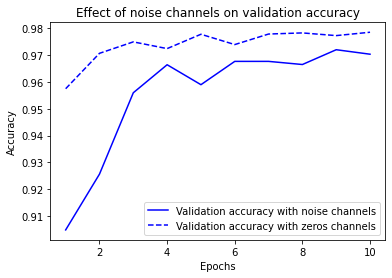

In [4]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

### The nature of generalization in deep learning

딥 러닝 모델은 표현력이 충분하다면 무엇에든 적합하도록 훈련할 수 있습니다.


**Fitting a MNIST model with randomly shuffled labels**

In [5]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 2s 3ms/step - loss: 2.3180 - accuracy: 0.1026 - val_loss: 2.3071 - val_accuracy: 0.1098
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3013 - accuracy: 0.1135 - val_loss: 2.3107 - val_accuracy: 0.1013
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2918 - accuracy: 0.1256 - val_loss: 2.3169 - val_accuracy: 0.1056
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2786 - accuracy: 0.1391 - val_loss: 2.3256 - val_accuracy: 0.1023
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2605 - accuracy: 0.1554 - val_loss: 2.3377 - val_accuracy: 0.1064
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2390 - accuracy: 0.1698 - val_loss: 2.3581 - val_accuracy: 0.1022
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2153 - accuracy: 0.1837 - val_loss: 2.3700 - val_accuracy: 0.1008

#### The manifold hypothesis

MNIST

* 28 x 28
* [0, 255]

가능한 입력 값들의 총 수는 $256^{784}$ 입니다.
우주에 있는 원자의 수보다 훨씬 더 많습니다.
그러나 실제 손으로 쓴 숫자는 상위 공간의 **고도로 구조화된 작은 하위 공간**만 차지합니다.

* 연속(continuous) (작은 수정 => 여전히 숫자)
* 부드러운 경로(smooth paths)로 연결됨( A에서 B로의 시퀀스, 모든 중간은 여전히 숫자처럼 보입니다)

**매니폴드(Manifold)** (국지적으로 선형(유클리드) 공간과 유사한 일부 상위 공간의 저차원 하위 공간(lower-dimensional subspace))

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-07.png" width="400"><p style="text-align:center">Figure 5.7 Different MNIST digits gradually morphing into one another, showing that the space of handwritten digits forms a “manifold.” This image was generated using code from chapter 12.</p>

매니폴드 가설은 다음을 의미합니다.
* 기계 학습 모델은 잠재적인 입력 공간(잠재적 다양체) 내에서 비교적 단순하고 저차원적이며 고도로 구조화된 하위 공간에만 적합해야 합니다.
* 이러한 다양체 중 하나 내에서 두 입력 사이를 보간하는 것이 항상 가능합니다.

#### Interpolation as a source of generalization

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-08.png" width="450"><p style="text-align:center">Figure 5.8 Difference between linear interpolation and interpolation on the latent manifold. Every point on the latent manifold of digits is a valid digit, but the average of two digits usually isn’t.</p>

#### Why deep learning works

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-09.png" width="500"><p style="text-align:center">Figure 5.9 Uncrumpling a complicated manifold of data</p>

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-10.png" width="500"><p style="text-align:center">Figure 5.10 Going from a random model to an overfit model, and achieving a robust fit as an intermediate state</p>

#### Training data is paramount

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-11.png" width="500"><p style="text-align:center">Figure 5.11 A dense sampling of the input space is necessary in order to learn a model capable of accurate generalization.</p>

## 5.2 Evaluating machine-learning models

### Training, validation, and test sets

모델 평가는 항상 사용 가능한 데이터를 **학습, 검증** 및 **테스트**의 3 가지 세트로 나누는 것으로 요약됩니다. 
* 훈련 데이터에 대해 훈련하고 
* 검증 데이터에 대해 모델을 평가하고
* 모델이 준비되면 테스트 데이터에서 마지막으로 한 번 테스트합니다. 

**훈련** 세트와 **테스트** 세트라는 2 개의 세트로만 하지 않는 이유 :
* 모델 개발에는 항상 구성 조정(tuning configuration)이 포함되기 때문입니다. (ex: 계층 수/계층 크기 선택(모델의 hyperparameter라고 하며 네트워크 가중치인 parameter와 구별). 
* 검증 데이터에 대한 모델의 성능을 피드백 신호로 사용하여 이 조정을 수행하며, 본질적으로 이 조정은 학습의 한 형태입니다. 
* 검증 세트에 대한 성능을 기반으로 모델 구성을 조정하면 모델이 직접 학습된 적이 없더라도 검증 세트에 빠르게 과적합될 수 있습니다.

#### Simple hold-out validation

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-12.png" width="300"><p style="text-align:center">Figure 5.12 Simple holdout validation split</p>

In [ ]:
# Not for running 
num_validation_samples = 10000 
np.random.shuffle(data)
validation_data = data[:num_validation_samples]
training_data   = data[num_valication_samples:]
model = get_model()
model.fit(training_data, ...)
validation_score = model.evaluate(validation_data, ...)
...
model = get_model()
model.fit(np.concatenate([training_data, validation_data], ...))
test_score = model.evaluate(test_data, ...)

#### K-fold validation

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-13.png" width="450"><p style="text-align:center">Figure 5.13 K-fold cross-validation with K=3</p>

In [ ]:
# Not for running 
k = 3 
num_validation_samples = len(data) / k
np.random.shuffle(data)
validation_scores = [] 
for fold in range(k):
    validation_data = data[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate(
        data[:num_validation_samples * fold],
        data[num_validation_samples * (fold + 1):])
    model = get_model()
    model.fit(training_data, ...)
    validation_score = model.evaluate(validation_data, ...)
    validation_scores.append(validation_score)
validation_score = np.average(validation_scores)
model = get_model()
model.fit(data, ...)
test_score = model.evaluate(test_data, ...)

#### Iterated K-fold validation with shuffling

### Beating a common-sense baseline

* 10% accuracy for MNIST
* 90% accuracy for an imbalanced dataset (90% A, 10% B -> always A)

### Things to keep in mind about model evaluation

* **데이터 대표성** (예: NOT 0-7 for train, 8-9 for test)
* **시간의 화살** 과거를 고려하여 미래를 예측하려는 경우 (예: 내일 날씨, 주식 움직임 등) 분할하기 전에 데이터를 무작위로 섞지 않아야 합니다. 그렇게 하면 일시적인 누수가 발생하기 때문입니다. 이러한 상황에서는 항상 테스트 세트의 모든 데이터가 훈련 세트의 데이터보다 뒤에 있는지 확인해야 합니다.(무작위 섞지 않음, 과거에 대한 학습, 미래에 대한 테스트)
* **데이터의 중복성** (중복 -> 무작위 셔플 -> 훈련 및 테스트에서 동일한 데이터)


## Improving model fit

Common problems 
* training not starting
* training starts but not generalize
* losses go down but no overfit

### Tuning key gradient descent parameters

**Training a MNIST model with an incorrectly high learning rate**

In [8]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),  # too big Learning Rate
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 5ms/step - loss: 1448.4965 - accuracy: 0.4599 - val_loss: 2.1796 - val_accuracy: 0.2142
Epoch 2/10
375/375 [==============================] - 1s 4ms/step - loss: 4.2263 - accuracy: 0.2613 - val_loss: 5.9095 - val_accuracy: 0.3006
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 3.1579 - accuracy: 0.2305 - val_loss: 2.7852 - val_accuracy: 0.2758
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 2.7479 - accuracy: 0.2279 - val_loss: 2.2426 - val_accuracy: 0.1782
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 2.6662 - accuracy: 0.2378 - val_loss: 2.0099 - val_accuracy: 0.2618
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 2.5700 - accuracy: 0.2329 - val_loss: 2.5483 - val_accuracy: 0.2068
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 2.5576 - accuracy: 0.2011 - val_loss: 3.0299 - val_accuracy: 0.2106
Epo

**The same model with a more appropriate learning rate**

In [9]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),  # appropriate LR
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 3ms/step - loss: 0.3478 - accuracy: 0.9122 - val_loss: 0.2153 - val_accuracy: 0.9442
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1403 - accuracy: 0.9642 - val_loss: 0.1948 - val_accuracy: 0.9616
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1128 - accuracy: 0.9732 - val_loss: 0.1533 - val_accuracy: 0.9692
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1026 - accuracy: 0.9779 - val_loss: 0.2139 - val_accuracy: 0.9689
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0877 - accuracy: 0.9820 - val_loss: 0.2398 - val_accuracy: 0.9653
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0791 - accuracy: 0.9841 - val_loss: 0.2452 - val_accuracy: 0.9699
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0789 - accuracy: 0.9861 - val_loss: 0.2222 - val_accuracy: 0.9732
Epoch 

### Leveraging better architecture priors

### Increasing model capacity

**A simple logistic regression on MNIST**

In [10]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 1s 3ms/step - loss: 0.6704 - accuracy: 0.8355 - val_loss: 0.3584 - val_accuracy: 0.9043
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3509 - accuracy: 0.9032 - val_loss: 0.3089 - val_accuracy: 0.9157
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3154 - accuracy: 0.9123 - val_loss: 0.2896 - val_accuracy: 0.9199
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2991 - accuracy: 0.9164 - val_loss: 0.2833 - val_accuracy: 0.9199
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2895 - accuracy: 0.9190 - val_loss: 0.2757 - val_accuracy: 0.9239
Epoch 6/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2829 - accuracy: 0.9212 - val_loss: 0.2710 - val_accuracy: 0.9258
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2781 - accuracy: 0.9225 - val_loss: 0.2708 - val_accuracy: 0.9254
Epoch 

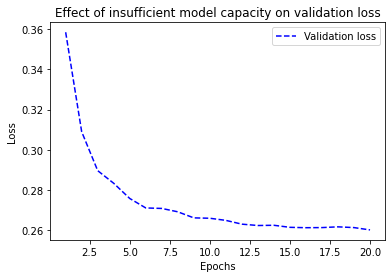

In [11]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-14.png" width="400"><p style="text-align:center">Figure 5.14 Effect of insufficient model capacity on loss curves</p>

In [12]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 0.3625 - accuracy: 0.8992 - val_loss: 0.1830 - val_accuracy: 0.9476
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.1614 - accuracy: 0.9509 - val_loss: 0.1276 - val_accuracy: 0.9622
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.1125 - accuracy: 0.9661 - val_loss: 0.1120 - val_accuracy: 0.9675
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0854 - accuracy: 0.9740 - val_loss: 0.1009 - val_accuracy: 0.9701
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0684 - accuracy: 0.9797 - val_loss: 0.0959 - val_accuracy: 0.9722
Epoch 6/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0553 - accuracy: 0.9829 - val_loss: 0.0951 - val_accuracy: 0.9730
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0454 - accuracy: 0.9866 - val_loss: 0.0945 - val_accuracy: 0.9720
Epoch 

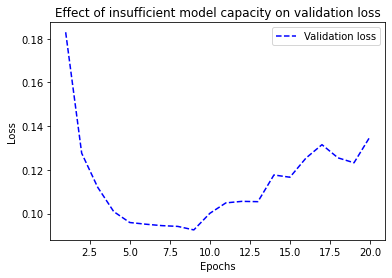

In [13]:
import matplotlib.pyplot as plt
val_loss = history_large_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-15.png" width="400"><p style="text-align:center">Figure 5.15 Validation loss for a model with appropriate capacity
</p>

## Improving generalization

### Dataset curation

### Feature engineering

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-16.png" width="400"><p style="text-align:center">Figure 5.16 Feature engineering for reading the time on a clock
</p>

### Using early stopping

일반화를 개선하기 위해 할 수 있는 가장 효과적인 방법 중 하나

**EarlyStopping** callback

In [15]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model_earlystop = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    callbacks=[callback],
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 0.3629 - accuracy: 0.8975 - val_loss: 0.1834 - val_accuracy: 0.9461
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.1582 - accuracy: 0.9536 - val_loss: 0.1248 - val_accuracy: 0.9628
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.1106 - accuracy: 0.9661 - val_loss: 0.1130 - val_accuracy: 0.9663
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0844 - accuracy: 0.9746 - val_loss: 0.1017 - val_accuracy: 0.9693
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0673 - accuracy: 0.9791 - val_loss: 0.0937 - val_accuracy: 0.9721
Epoch 6/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0552 - accuracy: 0.9833 - val_loss: 0.0911 - val_accuracy: 0.9746
Epoch 7/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0450 - accuracy: 0.9864 - val_loss: 0.0989 - val_accuracy: 0.9725
Epoch 

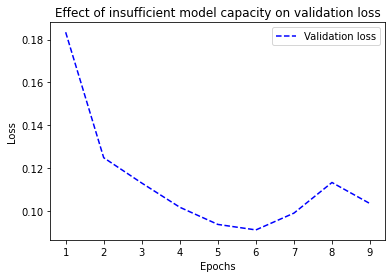

In [27]:
import matplotlib.pyplot as plt
val_loss = history_large_model_earlystop.history["val_loss"]
epochs = range(1, len(val_loss)+1)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Regularizing your model

#### Reducing the network's size

**Original model**

In [19]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

17473536/17464789 [==============================] - 0s 0us/step
Epoch 1/20
30/30 [==============================] - 2s 39ms/step - loss: 0.5120 - accuracy: 0.7858 - val_loss: 0.3824 - val_accuracy: 0.8702
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3028 - accuracy: 0.9049 - val_loss: 0.2996 - val_accuracy: 0.8885
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2189 - accuracy: 0.9283 - val_loss: 0.2803 - val_accuracy: 0.8908
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1758 - accuracy: 0.9429 - val_loss: 0.2802 - val_accuracy: 0.8898
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1412 - accuracy: 0.9553 - val_loss: 0.3129 - val_accuracy: 0.8785
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1205 - accuracy: 0.9629 - val_loss: 0.3120 - val_accuracy: 0.8807
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0994 - accurac

**Version of the model with lower capacity**

In [20]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 38ms/step - loss: 0.6132 - accuracy: 0.7600 - val_loss: 0.5314 - val_accuracy: 0.8504
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.4682 - accuracy: 0.8791 - val_loss: 0.4344 - val_accuracy: 0.8704
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3709 - accuracy: 0.8993 - val_loss: 0.3659 - val_accuracy: 0.8789
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2996 - accuracy: 0.9163 - val_loss: 0.3240 - val_accuracy: 0.8841
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2498 - accuracy: 0.9274 - val_loss: 0.2965 - val_accuracy: 0.8893
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2134 - accuracy: 0.9363 - val_loss: 0.2826 - val_accuracy: 0.8922
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1844 - accuracy: 0.9469 - val_loss: 0.2780 - val_accuracy: 0.8887
Epoch 8/20
30

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-17.png" width="400">
<p style="text-align:center">
Figure 5.17 Original model vs. smaller model on IMDB review classification
</p>

**Version of the model with higher capacity**

In [21]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 42ms/step - loss: 0.5524 - accuracy: 0.7737 - val_loss: 0.3290 - val_accuracy: 0.8705
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2688 - accuracy: 0.8983 - val_loss: 0.3130 - val_accuracy: 0.8667
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1532 - accuracy: 0.9430 - val_loss: 0.2738 - val_accuracy: 0.8930
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0697 - accuracy: 0.9759 - val_loss: 0.5385 - val_accuracy: 0.8459
Epoch 5/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1167 - accuracy: 0.9744 - val_loss: 0.3372 - val_accuracy: 0.8889
Epoch 6/20
30/30 [==============================] - 1s 26ms/step - loss: 0.0055 - accuracy: 0.9995 - val_loss: 0.5119 - val_accuracy: 0.8901
Epoch 7/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.6092 - val_accuracy: 0.8881
Epoch 8/20
30

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-18.png" width="400">
<p style="text-align:center">
Figure 5.18 Original model vs. much larger model on IMDB review classification</p>

#### Adding weight regularization

**Adding L2 weight regularization to the model**

In [22]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 36ms/step - loss: 0.5889 - accuracy: 0.7817 - val_loss: 0.4778 - val_accuracy: 0.8470
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3968 - accuracy: 0.8975 - val_loss: 0.3966 - val_accuracy: 0.8792
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3343 - accuracy: 0.9153 - val_loss: 0.3688 - val_accuracy: 0.8827
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3000 - accuracy: 0.9270 - val_loss: 0.3650 - val_accuracy: 0.8878
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2847 - accuracy: 0.9293 - val_loss: 0.3805 - val_accuracy: 0.8754
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2664 - accuracy: 0.9369 - val_loss: 0.3656 - val_accuracy: 0.8834
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2595 - accuracy: 0.9397 - val_loss: 0.3655 - val_accuracy: 0.8846
Epoch 8/20
30

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-19.png" width="400">
<p style="text-align:center">
Figure 5.19 Effect of L2 weight regularization on validation loss</p>

**Different weight regularizers available in Keras**

In [23]:
from tensorflow.keras import regularizers
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

#### Adding dropout

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-20.png" width="400"><p style="text-align:center">
Figure 5.20 Dropout applied to an activation matrix at training time, with rescaling happening during training. At test time the activation matrix is unchanged.</p>

**Adding dropout to the IMDB model**

In [24]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 34ms/step - loss: 0.6327 - accuracy: 0.6470 - val_loss: 0.5188 - val_accuracy: 0.8433
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5084 - accuracy: 0.7757 - val_loss: 0.3966 - val_accuracy: 0.8740
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.4201 - accuracy: 0.8339 - val_loss: 0.3411 - val_accuracy: 0.8805
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3569 - accuracy: 0.8664 - val_loss: 0.2988 - val_accuracy: 0.8849
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3066 - accuracy: 0.8897 - val_loss: 0.2800 - val_accuracy: 0.8910
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2627 - accuracy: 0.9097 - val_loss: 0.2745 - val_accuracy: 0.8919
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2337 - accuracy: 0.9197 - val_loss: 0.2775 - val_accuracy: 0.8917
Epoch 8/20
30

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/05-21.png" width="400">
<p style="text-align:center">
Figure 5.21 Effect of dropout on validation loss</p>

## Summary

* 모델의 목적 : 일반화
* 일반화 : 샘플 간 보간(학습 데이터의 잠재 매니폴드 학습)
* 최적화 대 일반화
* 분할: 훈련, 검증, 테스트 세트
* 먼저 일반화와 과적합을 달성하십시오. learning Rate/batch size 조정, 아키텍처 우선순위, 모델 용량, 더 긴 학습 등.
* 과적합 후: 일반화를 개선합니다. 정규화/조기 중지, 더 나은 데이터 세트 등.